# Create the dataset of subsampled real raw seismograms

## Load the image

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema
from tqdm import tqdm
from scipy.special import factorial

# Set rcParams to customize tick labels and spines
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

<class 'numpy.ndarray'>
(2849, 8867)


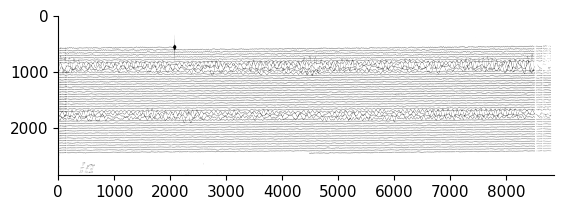

In [2]:
image_filepath = r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\raw\UCC19540112Gal_E_0750_binary.jpg"

image = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)

print(type(image))
print(image.shape)

plt.imshow(image, cmap='gray')
plt.grid(False)
plt.show()


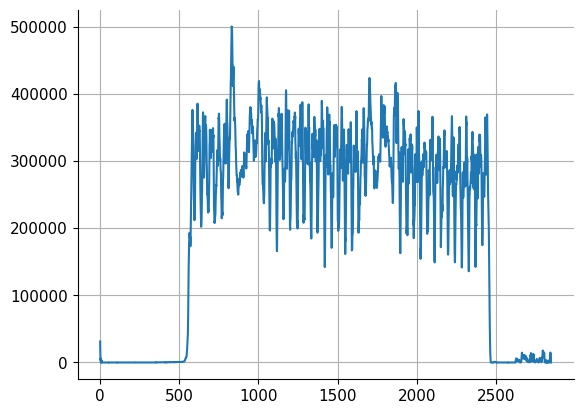

In [3]:
inv_image = np.max(image) - image

# Print sum of pixel values in the rows
row_sum = np.sum(inv_image, axis=1)
plt.plot(row_sum)
plt.show()

In [4]:
inv_image.shape

(2849, 8867)

In [5]:
def get_valid_roi(image, min_adjacent_rows=3):
    """
    Extracts the region of interest (ROI) from a binary image where foreground pixels are 1.
    
    Parameters:
    - image (numpy array): Binary image with 0s as background and 1s as foreground.
    - min_adjacent_rows (int): Minimum number of consecutive nonzero rows to consider as valid ROI.
    
    Returns:
    - tuple: (start_row, end_row) of the valid ROI.
    """

    tresh = 0.025 * 255 * image.shape[1]

    row_sums = np.sum(image, axis=1)  # Sum along columns for each row
    nonzero_rows = np.where(row_sums > tresh)[0]  # Get indices of nonzero rows

    if len(nonzero_rows) == 0:
        return None  # No valid ROI

    # Identify contiguous nonzero row segments
    groups = []
    start = nonzero_rows[0]

    for i in range(1, len(nonzero_rows)):
        if nonzero_rows[i] != nonzero_rows[i - 1] + 1:
            groups.append((start, nonzero_rows[i - 1]))
            start = nonzero_rows[i]
    
    groups.append((start, nonzero_rows[-1]))  # Add last group

    # Filter out small groups
    valid_groups = [g for g in groups if g[1] - g[0] + 1 >= min_adjacent_rows]

    if not valid_groups:
        return None  # No valid region after filtering

    # Get final valid region (bounding box)
    start_row = valid_groups[0][0]
    end_row = valid_groups[-1][1]

    return start_row, end_row

# # Example usage
# image = np.array([
#     [0, 0, 0, 0],
#     [0, 1, 1, 0],
#     [0, 1, 1, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 1, 1, 0],
#     [0, 1, 1, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],  # Noise (single row of nonzero pixels)
#     [0, 1, 1, 0],
#     [0, 1, 1, 0],
#     [0, 1, 1, 0],
#     [0, 0, 0, 0]
# ])

roi_rows = get_valid_roi(inv_image, min_adjacent_rows=0.02*image.shape[0])
print("ROI row range:", roi_rows)

roi_cols = get_valid_roi(inv_image.T, min_adjacent_rows=0.02*image.shape[1])
print("ROI col range:", roi_cols)


ROI row range: (555, 2460)
ROI col range: (167, 8525)


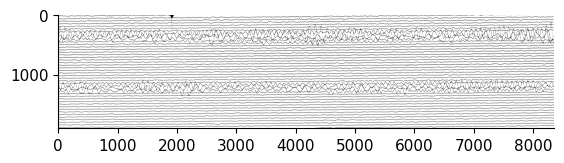

In [6]:
# crop the image to the ROI

image_cropped = image[roi_rows[0]:roi_rows[1], roi_cols[0]:roi_cols[1]]

plt.imshow(image_cropped, cmap='gray')
plt.grid(False)
plt.show()

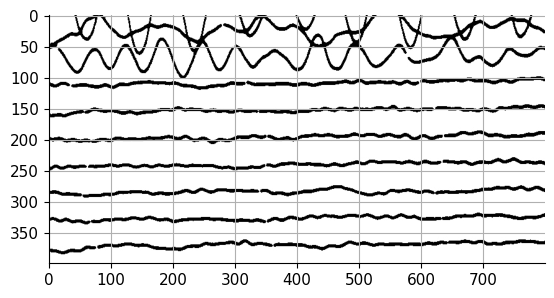

In [ ]:
# Set the tile size
tile_height = 400
tile_width = 800
folderpath = r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\seismograms"
os.makedirs(folderpath, exist_ok=True)

# Get image dimensions
img_height, img_width = image_cropped.shape

# Iterate over the image in vertical and horizontal tiles
num = 0  # Tile index

y_start = 0
while y_start + tile_height <= img_height:
    x_start = 0
    while x_start + tile_width <= img_width:
        # Extract tile
        tile = image_cropped[y_start:y_start + tile_height, x_start:x_start + tile_width]
        
        # Save tile
        filepath = os.path.join(folderpath, "image_{:05d}.jpg".format(num))
        plt.imsave(filepath, tile, dpi=300, cmap='gray')
        plt.imshow(tile, cmap='gray')

        # Move to the next tile in the horizontal direction
        x_start += tile_width
        num += 1  # Increment tile counter

    # Move to the next tile in the vertical direction
    y_start += tile_height
